# Brain Tumor Detection


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Custom Data Generator

USAMOS PyTorch EL CUAL GENERA MEJORES RESULTADO AL TRATAR Y GENERAR NUEVAS IMAGES

In [ ]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]

        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)

            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)

            image_array.append(array)

        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]

    def __repr__(self):
        return str(self.dataframe.head())

In [ ]:
dataset = BrainMRIDataset("../content/drive/MyDrive/brain_tumor_dataset/to_train_validate")
print(dataset)

                                               image  labels
0  ../content/drive/MyDrive/brain_tumor_dataset/t...       1
1  ../content/drive/MyDrive/brain_tumor_dataset/t...       1
2  ../content/drive/MyDrive/brain_tumor_dataset/t...       1
3  ../content/drive/MyDrive/brain_tumor_dataset/t...       0
4  ../content/drive/MyDrive/brain_tumor_dataset/t...       1


## Custom Neural Network Class

Esta clase heredara las propiedades de ```torch.nn.Module`` y debera tener dos funciones ```__init__`` para definir la red neuronal y ```forward`` para la propogación hacia adelante. En general, la función forward, se ocupará de la salida de cada capa. Podemos aplicar MaxPool, Dropouts y otras funciones de activación.

In [ ]:
class BrainTumorModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,256,kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,32,kernel_size=2)
        )
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [ ]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

# Convolutional Neural Network - Classification

## Model Training

1. Función de perdida: `torch.nn` Módulo que tiene funciones de pérdida predefinidas. Utilizando CrossEntropyLoss para 2 salidas, para examinar las probabilidades individuales

2. Optimizador: `torch.nn` teniendo optimizadores predefinidos, con muchos parámetros, aca usamos Adam

3. Después de definir los epochs, necesito hacer un bucle sobre algunos pasos
    * Ajustar los datos con el lote del conjunto de datos
    * Calcular la Pérdida
    * Hacer Cero el Gradiente, para los cálculos anteriores
    * Calcular la propogación hacia atrás (Cálculo de la derivada)
    * Optimizar el peso y los sesgos

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
epochs = 200
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(dataset)//batch_size):

        data,target = dataset[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target)

        total_loss += loss.item() # Use .item() to get the Python number from a tensor

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

<ipython-input-4-dcabe247151d>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]


Epochs: 0 Loss: 40.788557440042496
Epochs: 10 Loss: 0.5983238369226456
Epochs: 20 Loss: 0.03168536334608992
Epochs: 30 Loss: 0.0011539271460302796
Epochs: 40 Loss: 0.00046017694209391874
Epochs: 50 Loss: 0.00026649922559348244
Epochs: 60 Loss: 0.00018105138466732265
Epochs: 70 Loss: 0.00013326448546043443
Epochs: 80 Loss: 0.00010175922458680968
Epochs: 90 Loss: 8.065853095710433e-05
Epochs: 100 Loss: 6.564918749063509e-05
Epochs: 110 Loss: 5.4425915853547245e-05
Epochs: 120 Loss: 4.5883779421274085e-05
Epochs: 130 Loss: 3.919746268365998e-05
Epochs: 140 Loss: 3.3841315143945394e-05
Epochs: 150 Loss: 2.9471501723795274e-05
Epochs: 160 Loss: 2.5819272347386384e-05
Epochs: 170 Loss: 2.2830643805112533e-05
Epochs: 180 Loss: 2.0353544490111137e-05
Epochs: 190 Loss: 1.8247677720258555e-05


## Results
muestro el loss por cada epochs

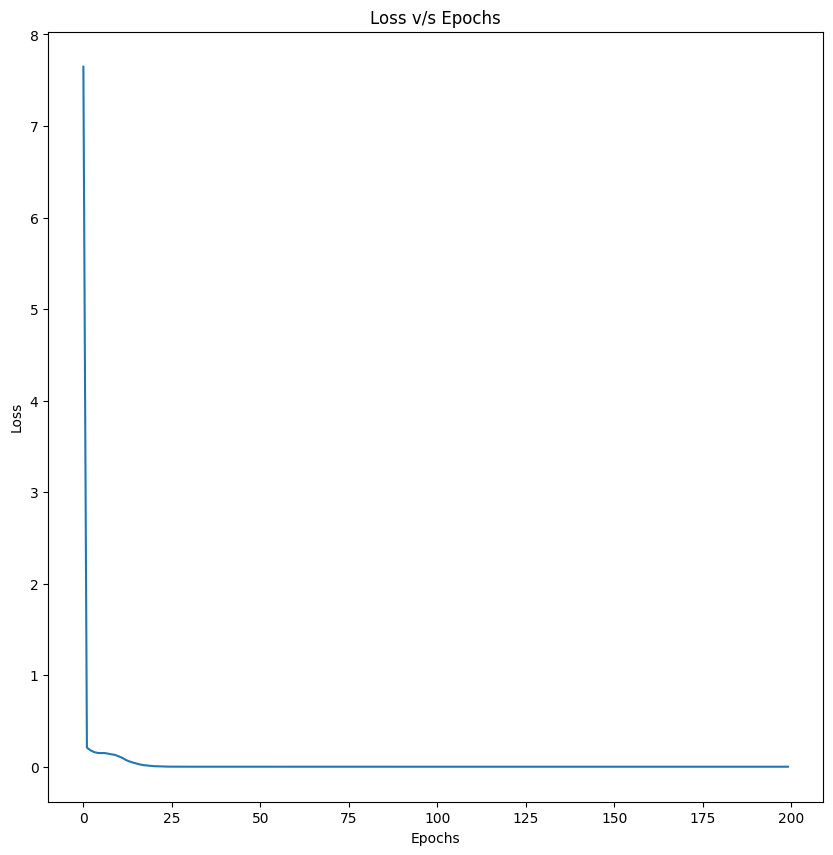

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

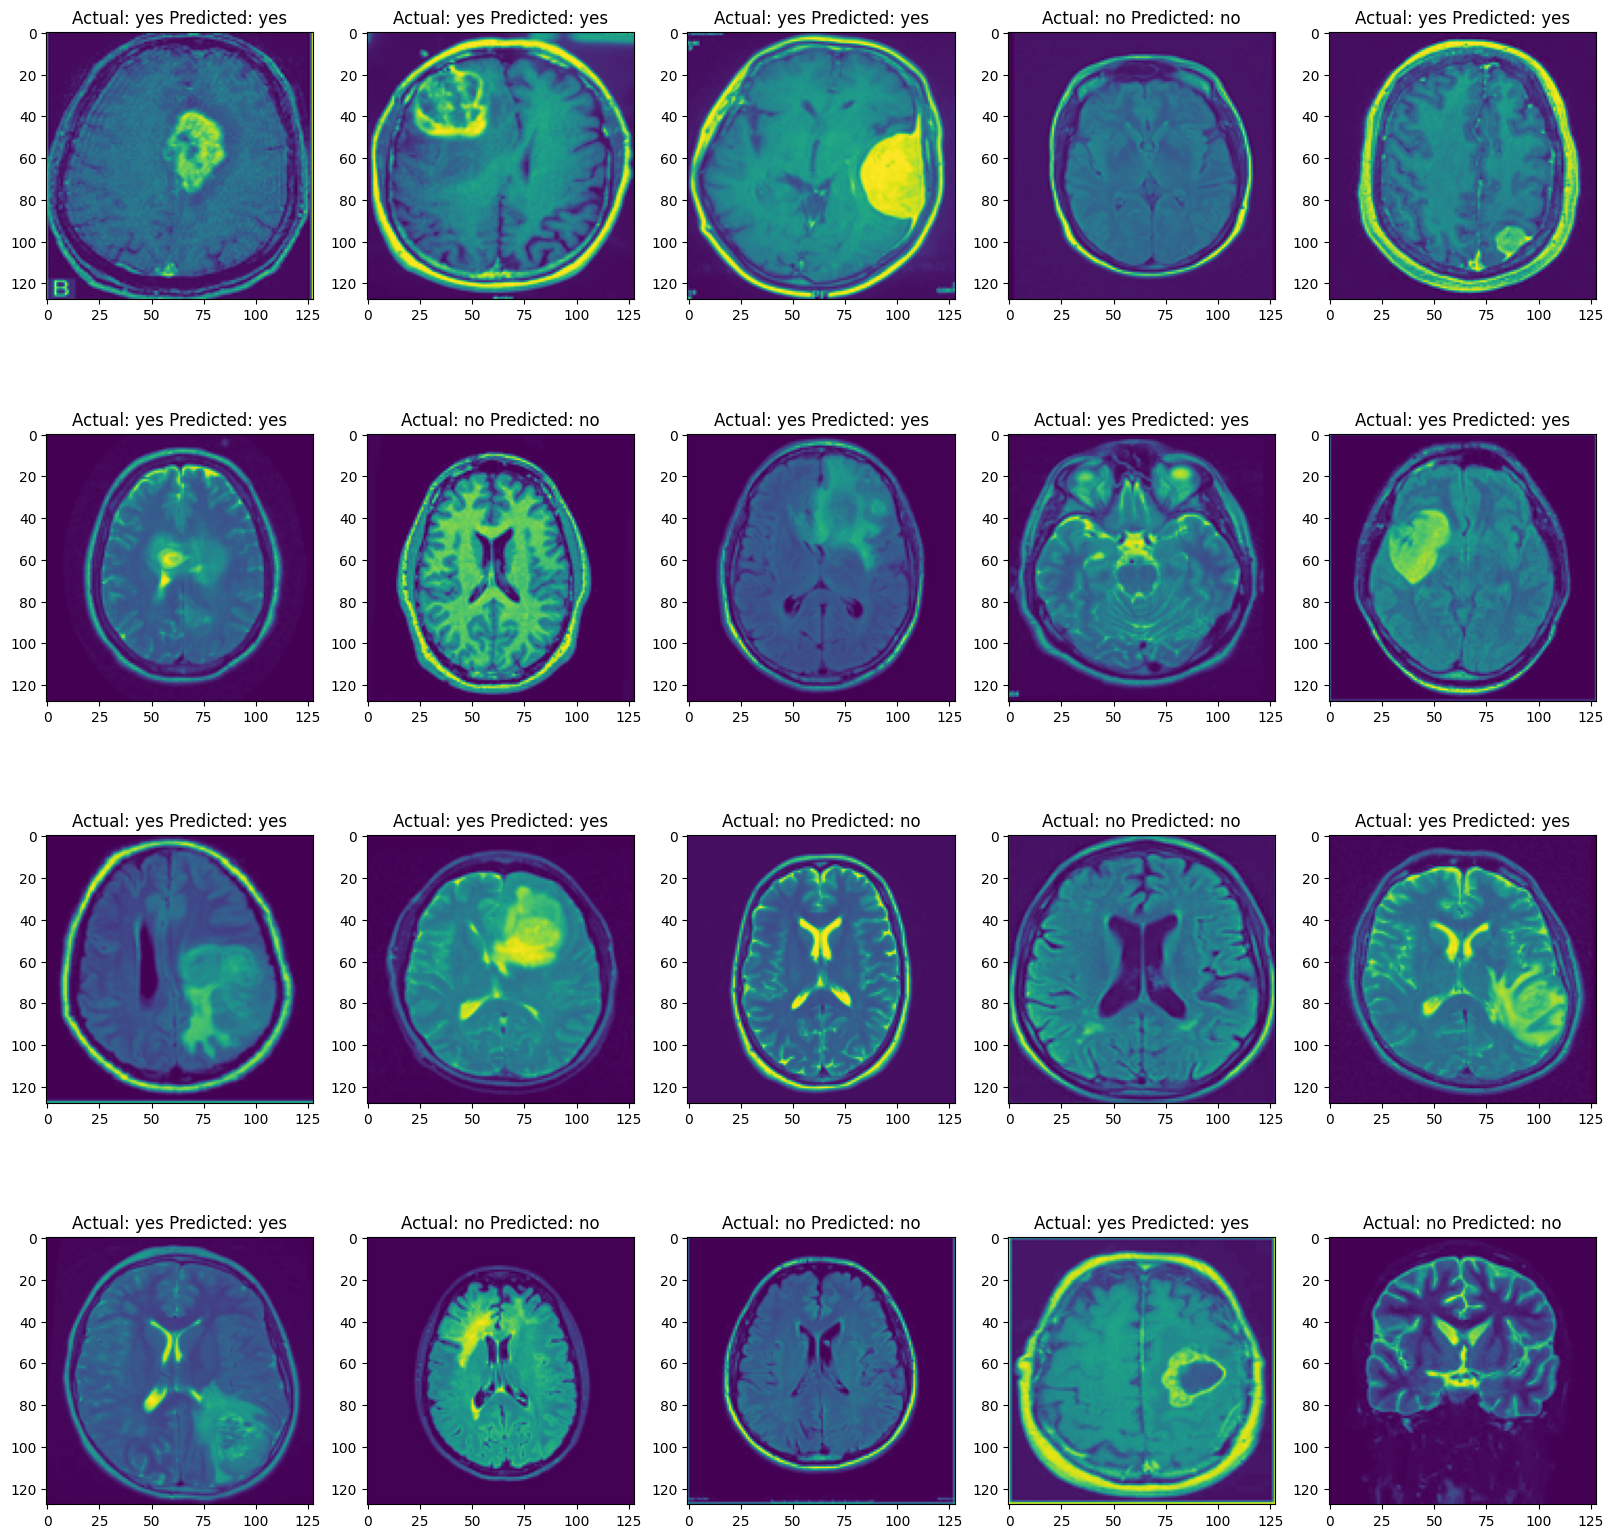

In [ ]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model.forward(data.float())
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()

# Autoencoder
  En esta parte, creare nuevas imagenes a traves de Autoencoder Implementation, entrenando con imagen de cerebro a raves del modelo.

In [ ]:
dataset_autoencoder = BrainMRIDataset("../content/drive/MyDrive/brain_tumor_dataset/to_train_validate",autoencoder=True,height=28,width=28)

In [ ]:
class BrainTumorAutoencodes(nn.Module):

    def __init__(self,dim):

        super().__init__()
        self.lin1 = nn.Linear(dim*dim,542)
        self.lin2 = nn.Linear(542,345)
        self.lin3 = nn.Linear(345,128)
        self.lin4 = nn.Linear(128,64)
        self.lin5 = nn.Linear(64,32)
        self.lin6 = nn.Linear(32,64)
        self.lin7 = nn.Linear(64,128)
        self.lin8 = nn.Linear(128,345)
        self.lin9 = nn.Linear(345,542)
        self.lin10 = nn.Linear(542,dim*dim)

    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = self.lin5(x)
        x = F.relu(self.lin6(x))
        x = F.relu(self.lin7(x))
        x = self.lin8(x)
        x = F.relu(self.lin9(x))
        x = F.relu(self.lin10(x))

        return x


In [ ]:
autoencoder = BrainTumorAutoencodes(28)
autoencoder.to(device)

BrainTumorAutoencodes(
  (lin1): Linear(in_features=784, out_features=542, bias=True)
  (lin2): Linear(in_features=542, out_features=345, bias=True)
  (lin3): Linear(in_features=345, out_features=128, bias=True)
  (lin4): Linear(in_features=128, out_features=64, bias=True)
  (lin5): Linear(in_features=64, out_features=32, bias=True)
  (lin6): Linear(in_features=32, out_features=64, bias=True)
  (lin7): Linear(in_features=64, out_features=128, bias=True)
  (lin8): Linear(in_features=128, out_features=345, bias=True)
  (lin9): Linear(in_features=345, out_features=542, bias=True)
  (lin10): Linear(in_features=542, out_features=784, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())

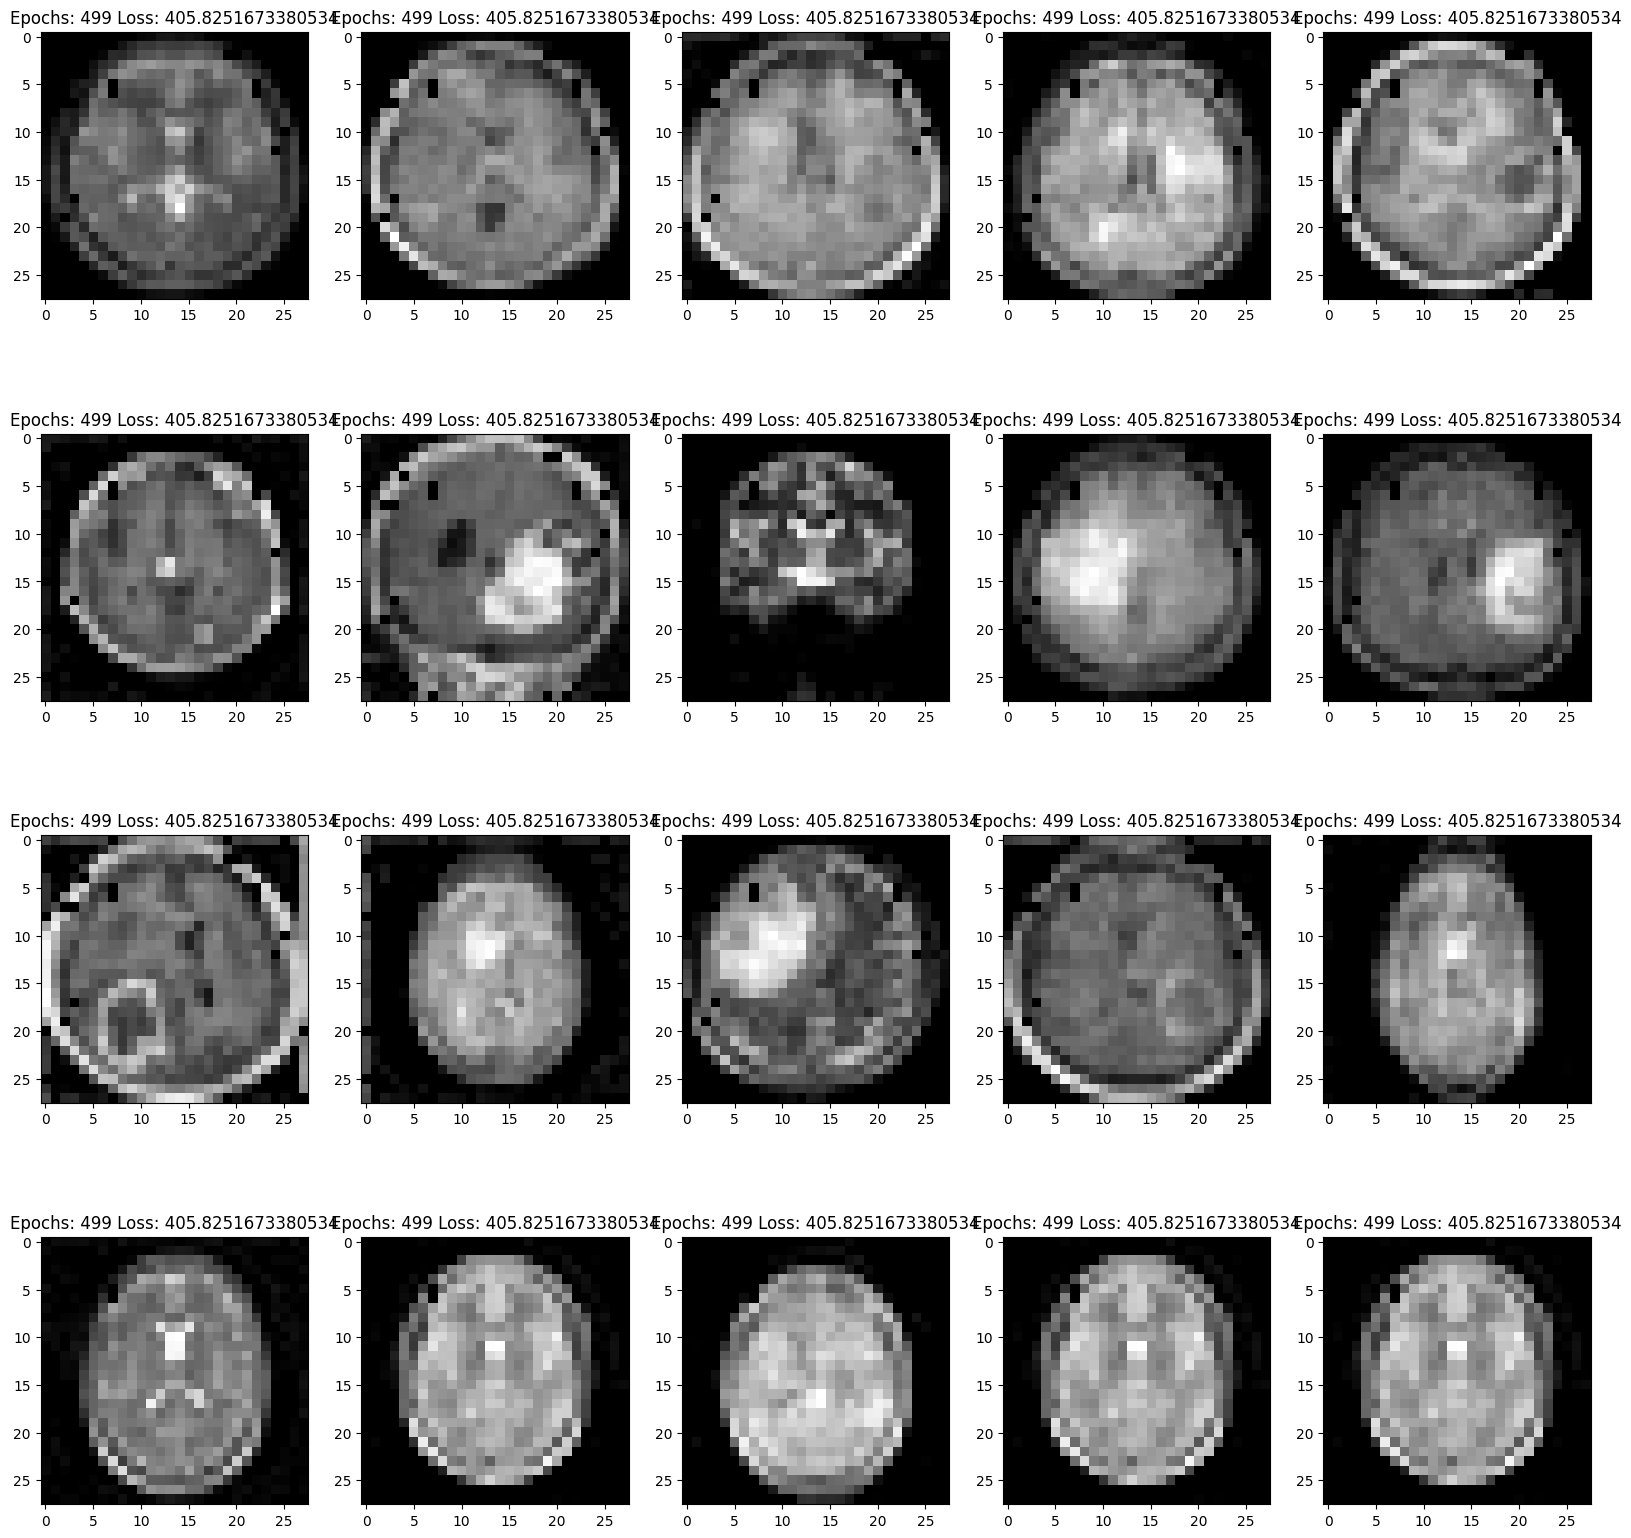

In [ ]:
from IPython.display import clear_output
epochs = 500
batch_size = 32
loss_list = []
for epoch in range(epochs):
    clear_output(True)
    total_loss = 0
    for n in range(len(dataset_autoencoder)//batch_size):

        data,target = dataset_autoencoder[n*batch_size:(n+1)*batch_size]

        ypred = autoencoder.forward(data.float())
        loss = loss_fn(ypred,data.float())

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(total_loss/batch_size)

    figure = plt.figure(figsize=(20,20))
    for i in range(20):
        plt.subplot(4,5,i+1)
        image = ypred[i].cpu().detach().numpy()# plot the sample
        image = image.reshape(28,28)
        fig = plt.figure
        plt.imshow(image, cmap='gray')
        plt.title(f'Epochs: {epoch} Loss: {total_loss/n}')
    plt.show()

**Visualize Image using trained model**

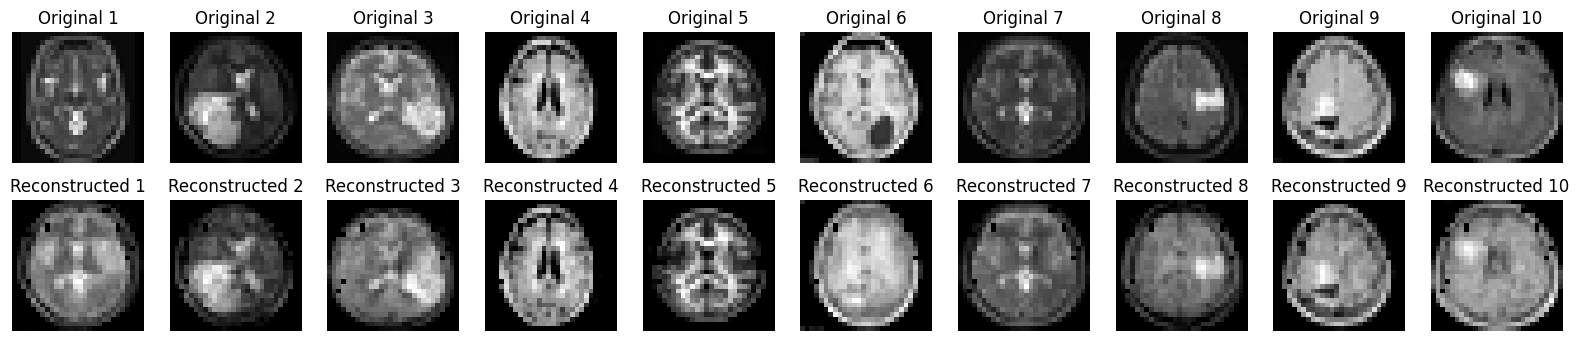

In [ ]:
# Function to visualize images

def visualize_reconstructions(model, dataset, num_images=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Operations inside don't track history
        data, _ = next(iter(torch.utils.data.DataLoader(dataset, batch_size=num_images)))
        data = data.float().to(device)
        reconstructed = model(data)  # Reconstruct the images using the autoencoder

        data = data.cpu().numpy()  # Move data back to CPU for visualization
        reconstructed = reconstructed.cpu().numpy()

        fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 4))
        for i in range(num_images):
            # Display original
            ax = axes[0, i]
            ax.imshow(data[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
            ax.set_title(f'Original {i+1}')

            # Display reconstruction
            ax = axes[1, i]
            ax.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
            ax.set_title(f'Reconstructed {i+1}')

        plt.show()

# Visualize 10 reconstructed images
visualize_reconstructions(autoencoder, dataset_autoencoder, num_images=10)